# Canada's Monetary Policy Report: if text could speak, what would it say?

## This notebook creates figures 6 and 7 in the Staff Analytical Note (Classifier performance and Sentiment).

## It applies a neural net approach based on https://github.com/fastai/fastai/blob/master/courses/dl2/imdb.ipynb

### This workbook should "just work". If it does not, or if you find an error, please email the authors.

##### André Binette <abinette@bankofcanada.ca>

##### Dmitri Tchebotarev


---------------------

## Set up the environment

### Import required modules

In [1]:
import sys, os
sys.path.insert(0,os.path.realpath("./fastai/old"))

from fastai.text import *

import warnings

from fastai.plots import *

from sklearn.metrics import confusion_matrix
import functools

from scipy.stats import zscore

import requests
from io import BytesIO
from zipfile import ZipFile
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import datetime as dt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

/home/res/bina/.conda/envs/mpr/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
torch.backends.cudnn.enabled = False

In [3]:
#This notebook uses pathlib for munging paths, which provides some additional functionality over plain strings.
PATH=Path('data/boc/')

CLAS_PATH=Path('data/boc_clas/')
CLAS_PATH.mkdir(exist_ok=True)

LM_PATH=Path('data/boc_lm/')
LM_PATH.mkdir(exist_ok=True)

---------

## Creating the training and validation set from all MPR sentences

In [4]:
# Fine tune the LM model we pass through all MPR sentences, regardless of whether they are
#labeled or not, we read in all the sentences.

CLASSES = ['neg', 'pos', 'unsup', 'meh']

def get_texts(path):
    texts,labels = [],[]
    for idx,label in enumerate(CLASSES):
        with open(str(path/(label+".txt")), "tr") as f:
            for line in f:
                texts.append("xbos xfld 1 " + line.rstrip())
                labels.append(idx)
    return np.array(texts),np.array(labels)

trn_texts,trn_labels = get_texts(PATH/'train')

In [5]:
# Total number of sentences
len(trn_texts)

14921

### We use a random permutation np array to shuffle the sentences.

In [6]:
np.random.seed(np.prod([ord(c) for c in 'deaa']))
trn_idx = np.random.permutation(len(trn_texts))
trn_texts = trn_texts[trn_idx]
trn_labels = trn_labels[trn_idx]

### Then use scikit-learn to split into a training and validation set.

In [7]:
trn_texts,val_texts = sklearn.model_selection.train_test_split(
    np.concatenate([trn_texts]), test_size=0.1)

In [8]:
len(trn_texts), len(val_texts)

(13428, 1493)

### Format the data and store them as CSV files

In [9]:
col_names = ['labels','text']

df_trn = pd.DataFrame({'text':trn_texts, 'labels':[0]*len(trn_texts)}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':[0]*len(val_texts)}, columns=col_names)

df_trn.to_csv(LM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(LM_PATH/'test.csv', header=False, index=False)

----------

## Language model tokens

In this section, we use the [spacy](http://spacy.io) library to tokenize the data. Since spacy does not provide a parallel/multicore version of the tokenizer, the fastai library adds this functionality. This parallel version uses all the cores of your CPUs and runs much faster than the serial version of the spacy tokenizer.

Tokenization is the process of splitting the text into separate tokens so that each token can be assigned a unique index. This means we can convert the text into integer indexes which our models can use.

We use an appropriate chunksize as the tokenization process is memory intensive.

In [10]:
def get_tokenized_texts(df, n_lbls=1, tokenizer=Tokenizer()):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = df.iloc[:,1].astype(str)
    tok = [tokenizer.proc_text(s) for s in texts]
    return tok, list(labels)

In [11]:
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None)#, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/'test.csv', header=None)#, chunksize=chunksize)

In [12]:
tok_trn, trn_labels = get_tokenized_texts(df_trn)
tok_val, val_labels = get_tokenized_texts(df_val)

In [13]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(10)

[('the', 25059),
 (',', 15700),
 ('in', 15426),
 ('1', 13844),
 ('.', 13431),
 ('xbos', 13428),
 ('xfld', 13428),
 ('of', 11814),
 ('to', 10614),
 ('and', 8631)]

In [14]:
max_vocab = 3000
min_freq = 2

itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

In [15]:
len(itos)

3002

We create a reverse mapping called stoi which is useful to lookup the index of a given token. stoi also has the same number of elements as itos. We use a high performance container called [collections.defaultdict](https://docs.python.org/2/library/collections.html#collections.defaultdict) to store our stoi mapping.

In [16]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
vs = len(itos)

In [17]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

---------------

## wikitext103 conversion

We are now going to build an english language model. We could start from scratch and try to learn the structure of the english language. But we use a technique called transfer learning to make this process easier. In transfer learning a pre-trained LM that has been trained on a large generic corpus(_like wikipedia articles_) can be used to transfer it's knowledge to a target LM and the weights can be fine-tuned.

Our source LM is the wikitext103 LM created by Stephen Merity @ Salesforce research. [Link to dataset](https://www.salesforce.com/products/einstein/ai-research/the-wikitext-dependency-language-modeling-dataset/)
The language model for wikitext103 (AWD LSTM) has been pre-trained and the weights can be downloaded here: [Link](http://files.fast.ai/models/wt103/). Our target LM is the IMDB LM. 

In [18]:
#! wget -nH -r -np -P {PATH} http://files.fast.ai/models/wt103/

The pre-trained LM weights have an embedding size of 400, 1150 hidden units and just 3 layers. We need to match these values  with the target LM so that the weights can be loaded up.

In [19]:
em_sz,nh,nl = 400,1150,3

In [20]:
PRE_PATH = PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

In [21]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

We calculate the mean of the layer0 encoder weights. This can be used to assign weights to unknown tokens when we transfer to target LM.

In [22]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [23]:
itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

Before we try to transfer the knowledge from wikitext to the LM, we match up the vocab words and their indexes. 
We use the defaultdict container once again, to assign mean weights to unknown tokens that do not exist in wikitext103.

In [24]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

We now overwrite the weights into the wgts odict.
The decoder module, which we will explore in detail is also loaded with the same weights due to an idea called weight tying.

In [25]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

Now that we have the weights prepared, we are ready to create and start training our new language pytorch model!

## Language model

It is fairly straightforward to create a new language model using the fastai library. Our model will have a backbone and a custom head. The backbone in our case is the LM pre-trained with wikitext and the custom head is a linear classifier. In this section we will focus on the backbone LM and the next section will talk about the classifier custom head.

bptt (*also known traditionally in NLP LM as ngrams*) in fastai LMs is approximated to a std. deviation around 70, by perturbing the sequence length on a per-batch basis. This is akin to shuffling our data in computer vision, only that in NLP we cannot shuffle inputs and we have to maintain statefulness. 

Since we are predicting words using ngrams, we want our next batch to line up with the end-points of the previous mini-batch's items. batch-size is constant and but the fastai library expands and contracts bptt each mini-batch using a clever stochastic implementation of a batch. (original credits attributed to [Smerity](https://twitter.com/jeremyphoward/status/980227258395770882))

In [26]:
wd=1e-7
bptt=70
bs=64
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

The goal of the LM is to learn to predict a word/token given a preceeding set of words(tokens). We take all the sentences in both the training set and validation set and concatenate them to form long strings of tokens. In fastai, we use the `LanguageModelLoader` to create a data loader which makes it easy to create and use bptt sized mini batches. The  `LanguageModelLoader` takes a concatenated string of tokens and returns a loader.

We have a special modeldata object class for LMs called `LanguageModelData` to which we can pass the training and validation loaders and get in return the model itself.

In [27]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

We setup the dropouts for the model - these values have been chosen after experimentation. If you need to update them for custom LMs, you can change the weighting factor (0.7 here) based on the amount of data you have. For more data, you can reduce dropout factor and for small datasets, you can reduce overfitting by choosing a higher dropout factor. *No other dropout value requires tuning*

In [28]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*1#0.7

We first tune the last embedding layer so that the missing tokens initialized with mean weights get tuned properly. So we freeze everything except the last layer.

We also keep track of the *accuracy* metric.

In [29]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [30]:
learner.model.load_state_dict(wgts)

We set learning rates and fit our LM. We first run one epoch to tune the last layer which contains the embedding weights. This should help the missing tokens in the wikitext103 learn better weights.

In [31]:
lr=4e-3
lrs = lrs = np.array([lr/6,lr/3,lr,lr/2])

In [32]:
%%time
learner.fit(lrs, 1, wds=wd, use_clr=(32,10), cycle_len=50)

epoch      trn_loss   val_loss   accuracy                 
    0      4.738204   4.157265   0.321488  
    1      4.305157   3.720086   0.349857                 
    2      3.884904   3.344446   0.37704                  
    3      3.52687    3.060042   0.419873                 
    4      3.29097    2.900182   0.439794                 
    5      3.124517   2.799553   0.448869                 
    6      3.027772   2.730043   0.456418                 
    7      2.94754    2.68188    0.461483                 
    8      2.879241   2.638991   0.465901                 
    9      2.844203   2.61188    0.469015                 
    10     2.795701   2.585281   0.472044                 
    11     2.766382   2.563747   0.473917                 
    12     2.738594   2.551506   0.476207                 
    13     2.718729   2.538289   0.476987                 
    14     2.699024   2.526093   0.477679                 
    15     2.669751   2.512039   0.479321                 
    16     2

[2.4172083536783853, 0.4932840234703488]

In [33]:
learner.save('lm1')

In [34]:
learner.save_encoder('lm1_enc')

In [35]:
try: del learner
except: pass

## Classifier tokens

The classifier model is basically a linear layer custom head on top of the LM backbone. Setting up the classifier data is similar to the LM data setup except that we cannot use the unsup sentences this time.

In [36]:
CLASSES = ['neg', 'pos','meh']

trn_texts,trn_labels = get_texts(PATH/'train')
# val_texts,val_labels = get_texts(PATH/'test')

In [37]:
len(trn_texts)#,len(val_texts)

900

In [38]:
col_names = ['labels','text']

We use a random permutation np array to shuffle the text reviews.

In [39]:
np.random.seed(np.prod([ord(c) for c in 'deaa']))
trn_idx = np.random.permutation(len(trn_texts))
# val_idx = np.random.permutation(len(val_texts))

In [40]:
trn_texts = trn_texts[trn_idx]
# val_texts = val_texts[val_idx]

trn_labels = trn_labels[trn_idx]
# val_labels = val_labels[val_idx]

In [41]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':trn_labels}, columns=col_names)
df_val = df_trn.sample(len(df_trn)//10)
df_trn = df_trn[~df_trn.index.isin(df_val.index)]

In [42]:
tok_trn, trn_labels = get_tokenized_texts(df_trn)
tok_val, val_labels = get_tokenized_texts(df_val)

In [43]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [44]:
trn_labels = np.squeeze(trn_labels)
val_labels = np.squeeze(val_labels)

## Classifier

Now we can create our final model, a classifier which is really a custom linear head over our trained backbone. The steps to create the classifier model are similar to the ones for the LM.

In [45]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 64

In [46]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In the classifier, unlike LM, we need to read a sentence at a time and learn to predict it's sentiment as pos/neg. We do not deal with equal bptt size batches, so we have to pad the sequences to the same length in each batch. To create batches of similar sized, we use a sortish sampler method invented by [@Smerity](https://twitter.com/Smerity) and [@jekbradbury](https://twitter.com/jekbradbury)

The sortishSampler cuts down the overall number of padding tokens the classifier ends up seeing.

In [47]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [48]:
len(trn_ds)

810

In [49]:
len(val_ds)

90

## Training the language model and the classifier

dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])*1.4

In [50]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*1.35

In [51]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [52]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [53]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]

In [54]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])*2

In [55]:
wd = 1e-6
# wd = 0
learn.load_encoder('lm1_enc')

In [56]:
learn.freeze_to(-1)

In [57]:
# import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [58]:
%%time
learn.fit(lrs, 1, wds=wd, cycle_len=20, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                 
    0      1.113984   1.040521   0.566667  
    1      1.068938   0.89921    0.611111                 
    2      1.037036   0.845945   0.566667                 
    3      1.015312   0.817725   0.6                      
    4      0.989748   0.773899   0.633333                  
    5      0.986382   0.762966   0.655556                  
    6      0.980703   0.777572   0.688889                  
    7      0.979219   0.771307   0.688889                  
    8      0.974916   0.790074   0.7                       
    9      0.966882   0.75254    0.688889                  
    10     0.967451   0.775707   0.666667                  
    11     0.968132   0.786648   0.666667                  
    12     0.957135   0.756763   0.655556                  
    13     0.949537   0.771805   0.644444                  
    14     0.922454   0.78357    0.644444                  
    15     0.918733   0.756716   0.655556                  


[0.7510779950353834, 0.6222222288449605]

In [59]:
learn.save('clas_0')

In [60]:
learn.load('clas_0')

In [61]:
learn.freeze_to(-2)

In [62]:
%%time
learn.fit(lrs, 1, wds=wd, cycle_len=20, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                  
    0      0.920075   0.738577   0.655556  
    1      0.926131   0.732942   0.666667                  
    2      0.937815   0.727418   0.622222                  
    3      0.931443   0.71645    0.655556                  
    4      0.931675   0.680632   0.744444                  
    5      0.891684   0.648179   0.766667                  
    6      0.899113   0.669247   0.744444                  
    7      0.913757   0.672778   0.8                       
    8      0.886137   0.617714   0.855556                  
    9      0.884683   0.598212   0.8                       
    10     0.871842   0.611193   0.822222                  
    11     0.861563   0.589866   0.822222                  
    12     0.845505   0.592709   0.844444                  
    13     0.837334   0.588254   0.811111                  
    14     0.850592   0.598448   0.733333                  
    15     0.847119   0.596153   0.755556               

[0.5992028673489889, 0.766666669315762]

In [63]:
learn.save('clas_1')

In [64]:
learn.load('clas_1')

In [65]:
learn.unfreeze()

In [66]:
%%time
learn.fit(lrs*1, 2, wds=wd, cycle_len=30, use_clr=(8,8))

epoch      trn_loss   val_loss   accuracy                  
    0      0.810904   0.564955   0.8       
    1      0.833903   0.525123   0.844444                  
    2      0.830276   0.528322   0.855556                  
    3      0.813517   0.509737   0.866667                  
    4      0.796316   0.46778    0.866667                  
    5      0.794056   0.455714   0.866667                  
    6      0.780719   0.446851   0.866667                  
    7      0.769664   0.420705   0.877778                  
    8      0.761432   0.398866   0.877778                  
    9      0.734596   0.377794   0.888889                  
    10     0.720827   0.340944   0.911111                  
    11     0.675594   0.34536    0.888889                  
    12     0.686546   0.353657   0.888889                  
    13     0.686168   0.382523   0.877778                  
    14     0.676448   0.375527   0.877778                  
    15     0.647493   0.333193   0.933333               

[0.2332757121986813, 0.933333326710595]

In [67]:
learn.save('clas_2')

In [68]:
learn.load('clas_2')

## Predictions and performance

In [69]:
@functools.lru_cache(maxsize=2**17)
def pred(sent, tokenizer=Tokenizer()):
    l = [stoi[p] for p in tokenizer.proc_text(sent)]
    arr = np.transpose(np.array([l]))    
    p = learn.predict_array(arr)[0]
    return F.softmax(T(p)).detach().cpu().numpy()

In sample
Accuracy: 0.9740740740740741 

[[263   2   1]
 [  7 268   1]
 [  3   7 258]]


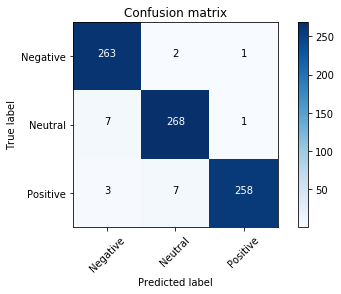

In [70]:
print("In sample")
t = df_trn['labels']
p = np.argmax(np.concatenate([pred(txt) for txt in df_trn.text]), axis=1)
cm = confusion_matrix(t,p)
print("Accuracy:", np.diag(cm).sum()/cm.sum(), "\n")
plot_confusion_matrix(cm,['Negative','Neutral','Positive'])

In validation
Accuracy: 0.9333333333333333 

[[32  2  0]
 [ 0 23  1]
 [ 1  2 29]]


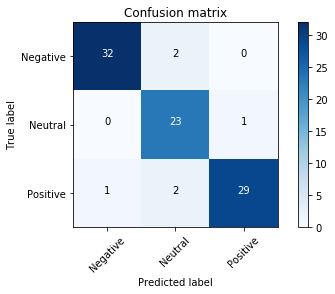

In [71]:
print("In validation")
t = df_val['labels']
p = np.argmax(np.concatenate([pred(txt) for txt in df_val.text]), axis=1)
cm = confusion_matrix(t,p)
print("Accuracy:", np.diag(cm).sum()/cm.sum(), "\n")
plot_confusion_matrix(cm,['Negative','Neutral','Positive'])

### Figure 6 - classifier perfomance

In [72]:
# loading the test set
test_set = pd.read_csv('100labeled.csv')

In [73]:
test_set['pred'] = test_set.text.apply(lambda x:np.argmax(pred(x)))
test_set['pred'] = test_set['pred'].map({0:'neg',1:'pos',2:'neutral'})

Accuracy: 0.83 

[[34  1  3]
 [ 3 19  4]
 [ 5  1 30]]


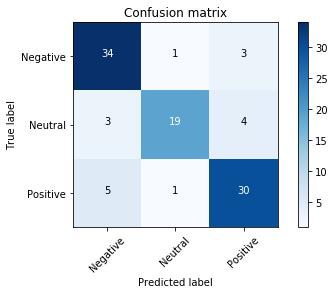

In [74]:
test_cm = confusion_matrix(test_set.value,test_set.pred)
print("Accuracy:", np.diag(test_cm).sum()/test_cm.sum(), "\n")
plot_confusion_matrix(test_cm,['Negative','Neutral','Positive'])

plt.savefig('fig6.pdf',bbox_inches='tight')

## Calculating the sentiment for each MPR

In [75]:
files = os.listdir('mpr_text/')
files = [f for f in files if f.endswith('.txt')]
files2 = []
for file in files:
    y,mm,d=map(int,file.split('.')[0].split('-')[1:])
    if y<2009 and mm in (1,2,7,8):
        continue
    if y==2009 and mm==1:
        continue
    files2.append(file)
files=files2

In [76]:
dates = list(sorted(['-'.join(f.split('.')[0].split('-')[1:]) for f in files]))

In [77]:
sentiment = pd.DataFrame(index=pd.DatetimeIndex(dates),columns=['Sentiment'])

In [78]:
nlp = spacy.load('en_core_web_lg')

In [79]:
def get_sent_mpr(date):
    file = 'mpr-'+date+'.txt'
    with open('mpr_text/'+file) as ff:
        text = ff.read()
    sents = list(nlp(text).sents)
    sents = [n.text for n in sents]
    pos = 0
    neg = 0
    neutral = 0
    for s in sents:
        tone = np.argmax(pred(s))
        if tone == 0:
            neg += 1
        elif tone == 1:
            pos += 1
        elif tone == 2:
            neutral += 1
    sentim = (pos - neg)/(pos + neg + neutral)
    return sentim

In [80]:
sentiment.loc[:,'Sentiment'] = list(map(get_sent_mpr,dates))
sentiment = sentiment.apply(zscore)

### Figure 7 - Sentiment

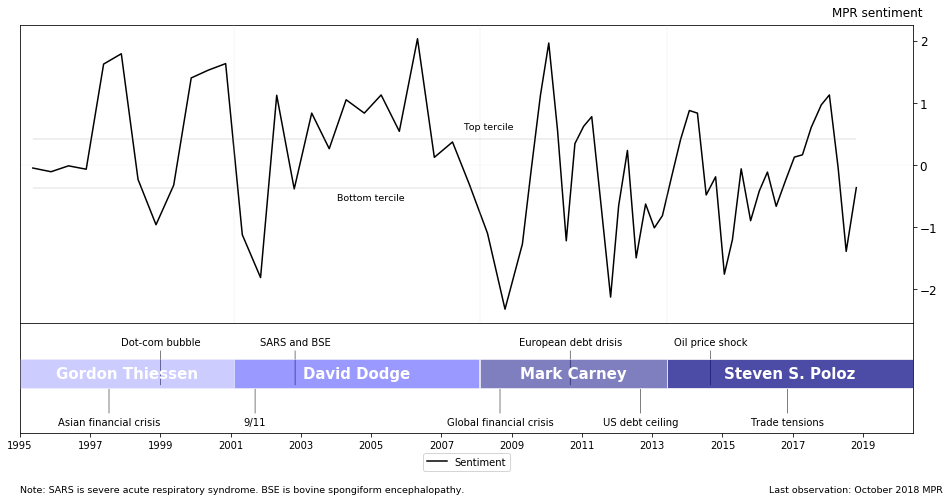

In [83]:
# Making the chart

fig, ((ax1, ax2)) = plt.subplots(2, 1, sharex=True, gridspec_kw = {'height_ratios':[3, 1]})
sentiment.plot(ax=ax1,figsize=(16,9),color='k')

bottom_tercile = pd.DataFrame(index=sentiment.index, columns=[''],data=np.percentile(sentiment.mean(axis=1),(100/3)*1,interpolation="nearest"))
top_tercile = pd.DataFrame(index=sentiment.index, columns=[''],data=np.percentile(sentiment.mean(axis=1),(100/3)*2,interpolation="nearest"))

bottom_tercile.plot(figsize=(16,9),alpha=1,ax=ax1,color='gray',linewidth=0.25)
top_tercile.plot(figsize=(16,9),alpha=1,ax=ax1,color='gray',linewidth=0.25)


ax1.axhline(0,color='k', linewidth=0.025)

ax1.axvline(dt.date(2001,2,1),color='lightgray', zorder=20,linewidth=.2)
ax1.axvline(dt.date(2008,2,1),color='lightgray', zorder=20,linewidth=.2)
ax1.axvline(dt.date(2013,6,3),color='lightgray', zorder=20,linewidth=.2)

plt.subplots_adjust(hspace=0)
#Import the GDP data from Statcan
table_num = "36100104"
link = f'https://www150.statcan.gc.ca/n1/tbl/csv/{table_num}-eng.zip'
r = requests.get(link)
zip_file = ZipFile(BytesIO(r.content))
GDP_fisher = pd.read_csv(zip_file.open(f'{table_num}.csv'), index_col=10,na_values=['..','...','x','F'])  

# Show only the necessary values using V-number
GDP_fisher = GDP_fisher.loc['v62305752']
Index2 = GDP_fisher.REF_DATE.values
GDP_fisher.index = Index2
GDP_fisher = GDP_fisher.drop(['REF_DATE', 'GEO', 'DGUID', 'Seasonal adjustment', 'UOM', 'UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID', 'COORDINATE', 'STATUS', 'SYMBOL', 'TERMINATED', 'DECIMALS'], axis =1)
GDP_fisher = GDP_fisher.pivot_table(index = GDP_fisher.index, columns = 'Prices', values = 'VALUE')
GDP_fisher.columns = ['real GDP (fisher)']
GDP_fisher = GDP_fisher.loc['1994-01':,]

# Create the year over year real GDP growth for each quarter 
GDP_fisher = (GDP_fisher/GDP_fisher.shift(4) - 1)*100
GDP_fisher = GDP_fisher.loc['1995-01':,]
GDP_fisher.columns = ['Real GDP Growth']

# Change to necessary date format for plot 
GDP_fisher.index = pd.to_datetime(GDP_fisher.index)
dates = mdates.date2num(GDP_fisher.index.to_pydatetime())
values = GDP_fisher.loc[:,'Real GDP Growth'].values

# Plot
ymax = 7
ymin = -4.5
difference = ymax - ymin

thiessenstarttime = (dt.date(1995,1,1))
thiessenendtime = (dt.date(2001,1,31))
thiessenstart = mdates.date2num(thiessenstarttime)
thiessenend = mdates.date2num(thiessenendtime)
thiessenwidth = thiessenend - thiessenstart 

dodgestarttime = (dt.date(2001,2,1))
dodgeendtime = (dt.date(2008,1,31))
dodgestart = mdates.date2num(dodgestarttime)
dodgeend = mdates.date2num(dodgeendtime)
dodgewidth = dodgeend - dodgestart 

carneystarttime = (dt.date(2008,2,1))
carneyendtime = (dt.date(2013,6,1))
carneystart = mdates.date2num(carneystarttime)
carneyend = mdates.date2num(carneyendtime)
carneywidth = carneyend - carneystart 

polozstarttime = (dt.date(2013,6,3))
polozendtime = (dt.date(2020,6,2))
polozstart = mdates.date2num(polozstarttime)
polozend = mdates.date2num(polozendtime)
polozwidth = polozend - polozstart 
rectangles = {'Gordon Thiessen' :patches.Rectangle((thiessenstart,.385*difference+ymin),
                                                   thiessenwidth,(.25*difference), linewidth = 1,
                                                   edgecolor ='w', facecolor='blue', zorder=5, alpha=.2),
              'David Dodge': patches.Rectangle((dodgestart,.385*difference+ymin),dodgewidth,
                                               (.25*difference), linewidth = 1, edgecolor ='w',
                                               facecolor='blue',zorder=5, alpha=.4),
              'Mark Carney': patches.Rectangle((carneystart,.385*difference+ymin),carneywidth
                                               ,(.25*difference), linewidth = 1, edgecolor ='w',
                                               facecolor='navy',zorder=5, alpha=.5),
              'Steven S. Poloz': patches.Rectangle((polozstart,.385*difference+ymin),polozwidth,
                                                   (.25*difference), linewidth = 1,edgecolor ='w',
                                                   facecolor='navy',zorder=5, alpha=.7)}
for r in rectangles:
    ax2.add_artist(rectangles[r])
    rx, ry = rectangles[r].get_xy()
    cx = rx + rectangles[r].get_width()/2.0
    cy = ry + rectangles[r].get_height()/2.0
    ax2.annotate(r, (cx, cy), color='white', weight='bold', 
                fontsize=15, ha='center', va='center', zorder=20)
ax2.set_xlim((dt.date(1995,1,1),dt.date(2020,6,2)))
years = pd.to_datetime(range(1995,2020,2), format='%Y')
yearnumbers = mdates.date2num(years.to_pydatetime())
ax2.set_xticks(yearnumbers)
ax2.set_yticks([])
starttime = (dt.date(1995,1,1))
endtime = (dt.date(2022,1,31))
start = mdates.date2num(starttime)
end = mdates.date2num(endtime)
plt.plot(dates,values, color='w')
annotations = sorted([
    (dt.date(1997,7,15),'Asian financial crisis',-3.5),
    (dt.date(1999,1,1),'Dot-com bubble',4.5),
    (dt.date(2001,9,11),'9/11',-3.5),
    (dt.date(2002,11,1),'SARS and BSE',4.5),
    (dt.date(2008,9,1),'Global financial crisis',-3.5),
    (dt.date(2010,9,1),'European debt drisis',4.5),
    (dt.date(2012,9,1),'US debt ceiling',-3.5),
    (dt.date(2014,9,1),'Oil price shock',4.5),
    (dt.date(2016,11,8),'Trade tensions',-3.5)
])
for q, a in enumerate(annotations):
    w = a[2]
    dm = mdates.date2num(a[0])
    plt.annotate(a[1],xy=(dm,0),xytext=(dm,.5*0 + w),\
            arrowprops=dict(facecolor='black', arrowstyle='-',linewidth=.5),\
            ha='center',va='center')
#, fontsize=11, weight='bold'
ax2.minorticks_off()
ax2.axhline(0,color='k',linewidth=.0025)
box1 = ax1.get_position()
box2 = ax2.get_position()
ax1.set_position([box1.x0, box1.y0 + box1.height * 0.1,
                 box1.width, box1.height * 0.9])
ax2.set_position([box2.x0, box2.y0+box1.height*0.1,
                 box2.width, box2.height])
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25-box2.height),\
          fancybox=True, shadow=False, ncol=4, fontsize = 'medium')
ax1.yaxis.tick_right()
plt.setp(ax1.get_xticklabels(), fontsize=12)
plt.setp(ax1.get_yticklabels(), fontsize=12)
ax1.set_ylabel("MPR sentiment", rotation='horizontal', fontsize=12)
ax1.yaxis.set_label_coords(0.96,1.02)

plt.text(0.125, 0.16, 'Note: SARS is severe acute respiratory syndrome. BSE is bovine spongiform encephalopathy.', transform=plt.gcf().transFigure, fontsize=9.5)
plt.text(.775, 0.16, 'Last observation: October 2018 MPR', transform=plt.gcf().transFigure, fontsize=9.5)

plt.text(.51, 0.72, 'Top tercile', transform=plt.gcf().transFigure, fontsize=9.5)
plt.text(.4, 0.61, 'Bottom tercile', transform=plt.gcf().transFigure, fontsize=9.5)

plt.savefig('fig7.pdf',bbox_inches='tight')